### Task 1 - Preparación del conjunto de datos


In [1]:
#Importación de las bibliotecas
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F

# Cargar el dataset
iris = load_iris()
X = iris.data
y = iris.target

# Escalar los datos
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convertir a tensores de PyTorch
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

# Dividir en conjuntos de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# Crear DataLoader para batches
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)



### Task 2 - Arquitectura modelo


In [2]:
# Definicion de la arquitectura del modelo

class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = F.relu(self.fc1(x))  # Activación ReLU en la primera capa oculta
        out = F.relu(self.fc2(out))  # Activación ReLU en la segunda capa oculta
        out = self.fc3(out)  # No aplicamos activación aquí porque la función de pérdida lo manejará
        return out

# Inicializamos el modelo 4 neuronas ya que tiene 4 caracteristicas el conjunto de iris y 3 porque hay 3 clases en el conjunto de datos de Iris
model = SimpleNN(input_size=4, hidden_size=10, output_size=3)


### Task 3 - Funciones de Pérdida

In [3]:
# Funcion de perdida
criterion_ce = nn.CrossEntropyLoss()
criterion_mse = nn.MSELoss()
criterion_nll = nn.NLLLoss()

# Para CrossEntropyLoss y NLLLoss
# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

### Task 4 - Técnicas de Regularización

In [4]:
# L2 Regularization
optimizer_l2 = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.01)

# L1 Regularization, implemented in the loss function
def l1_penalty(model, l1_lambda):
    l1_norm = sum(p.abs().sum() for p in model.parameters())
    return l1_lambda * l1_norm

# Dropout can be added in the model architecture
class SimpleNNWithDropout(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNNWithDropout, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model_dropout = SimpleNNWithDropout(input_size=4, hidden_size=10, output_size=3)


### Task 5 - Algoritmos de Optimización


In [5]:
# Stochastic Gradient Descent (SGD)
optimizer_sgd = torch.optim.SGD(model.parameters(), lr=0.01)

# Mini-Batch Gradient Descent is implicitly handled by DataLoader
# Adam Optimizer
optimizer_adam = torch.optim.Adam(model.parameters(), lr=0.01)


### Task 6 - Experimentación y Análisis


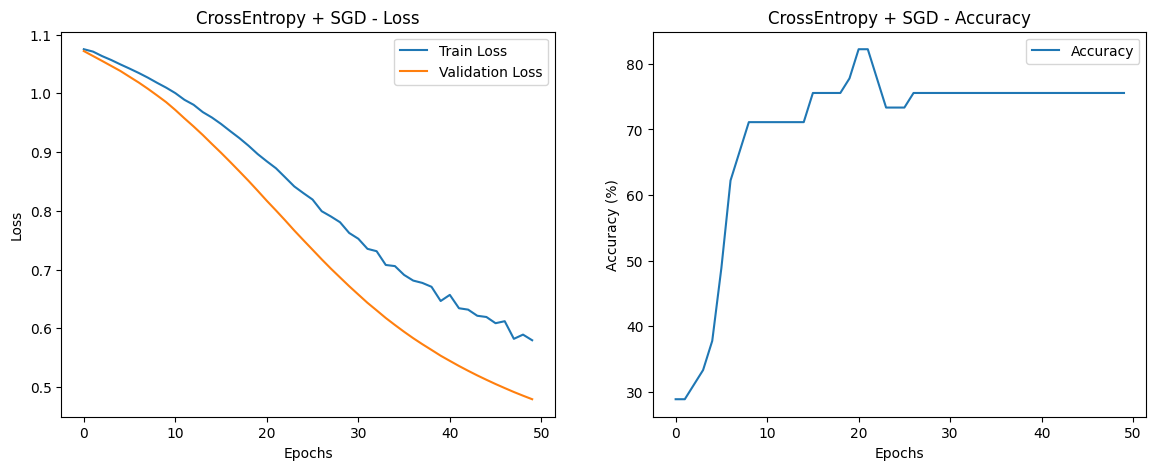

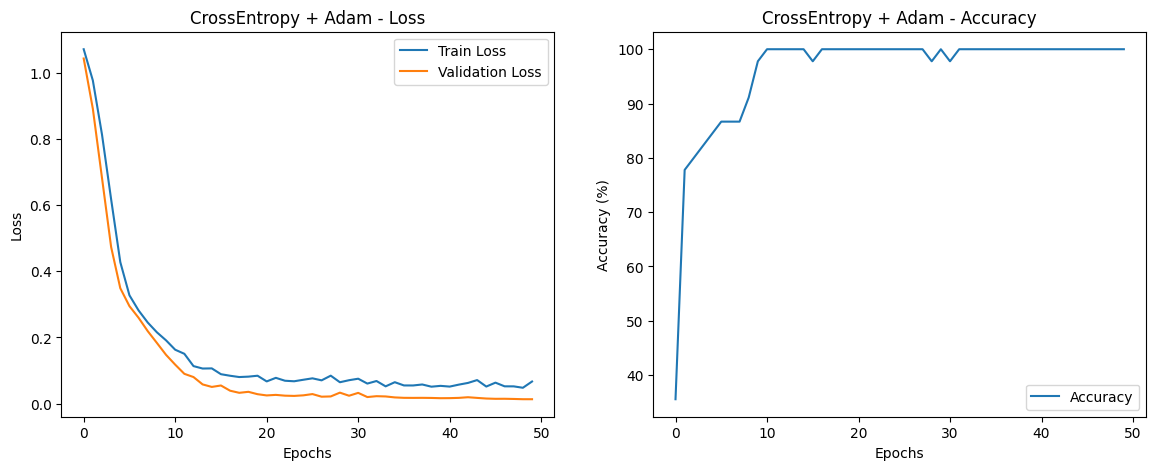

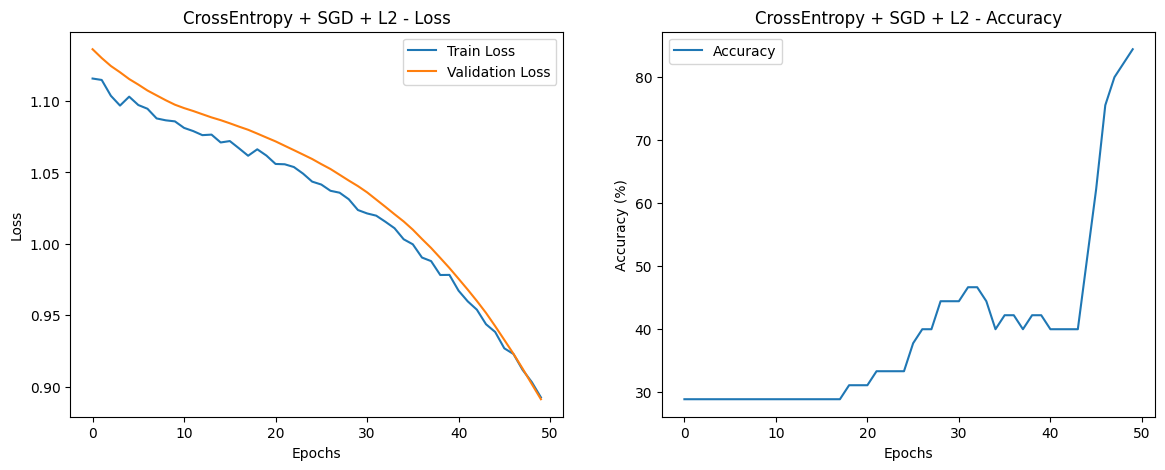

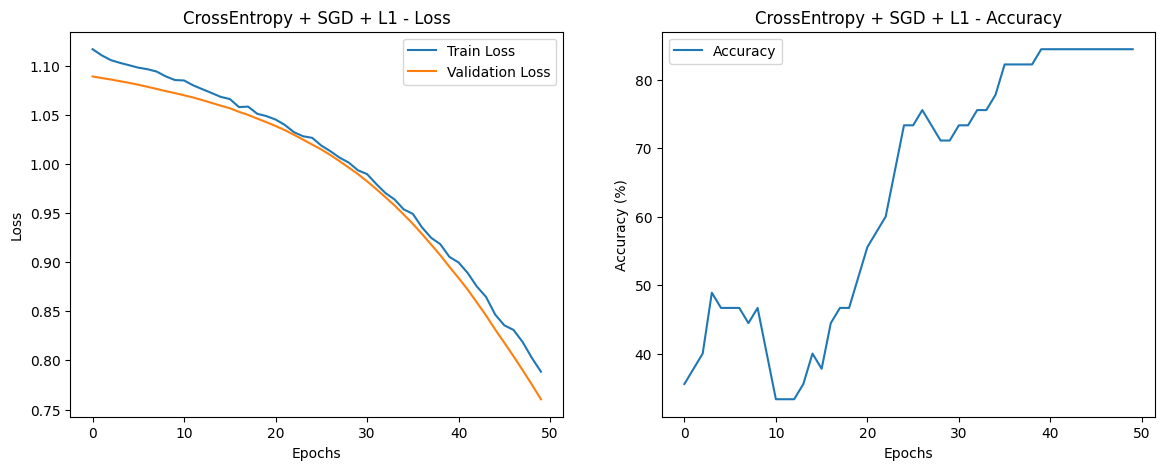

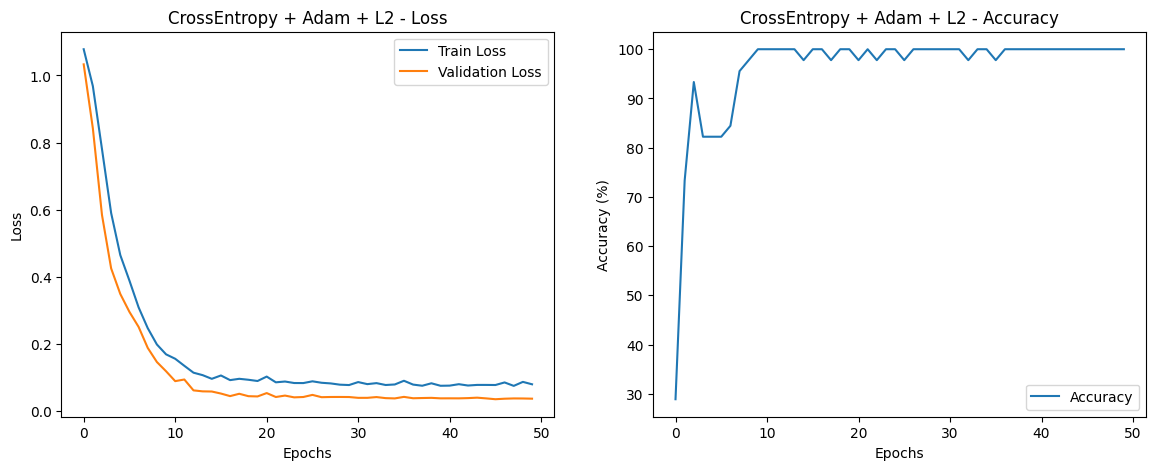

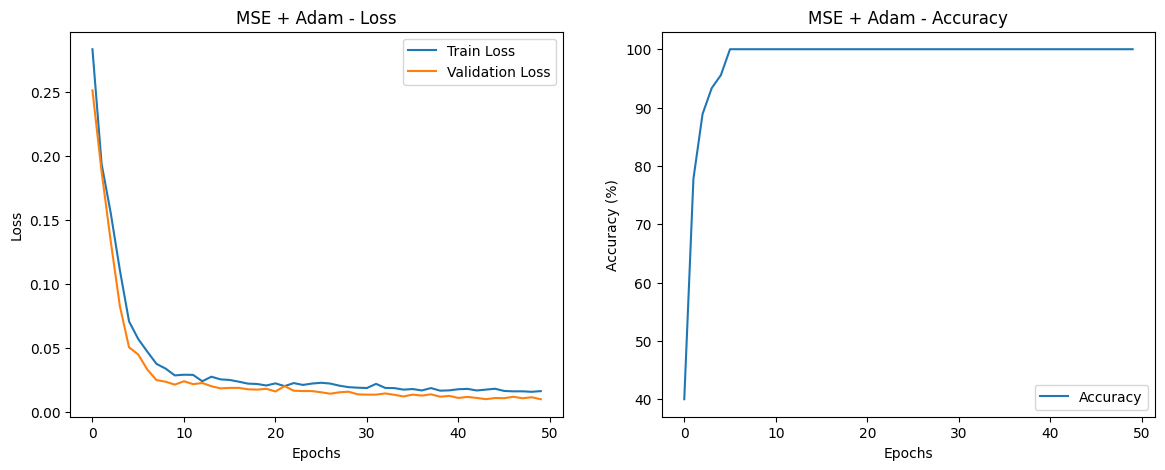

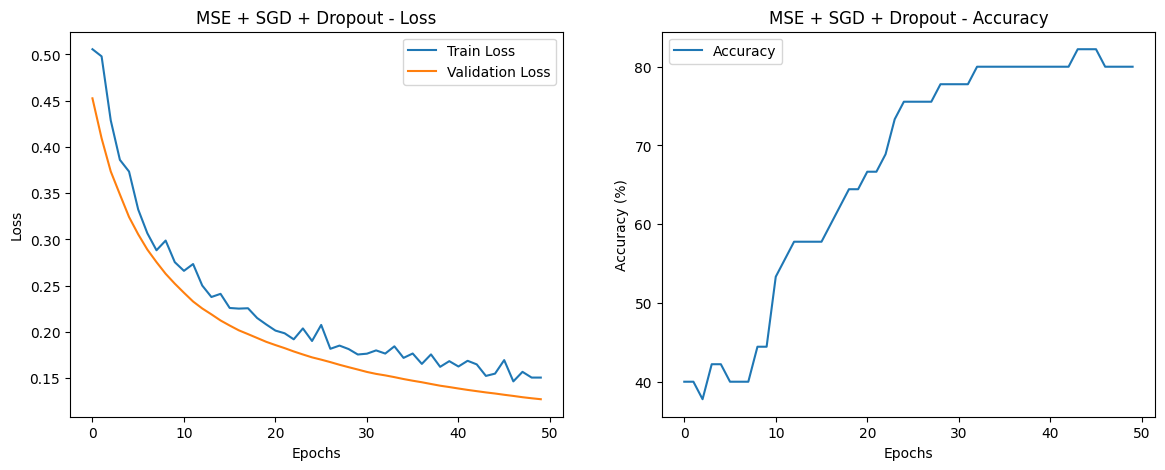

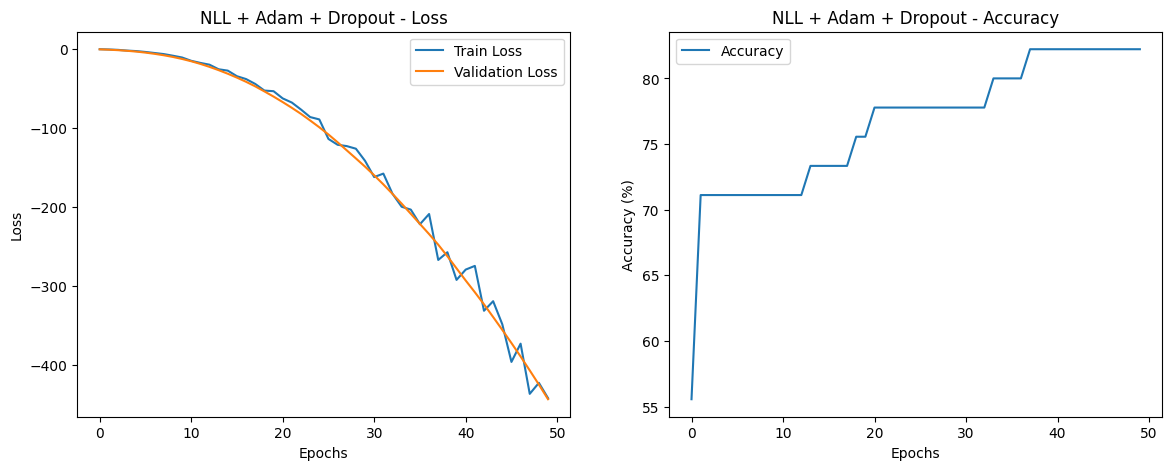

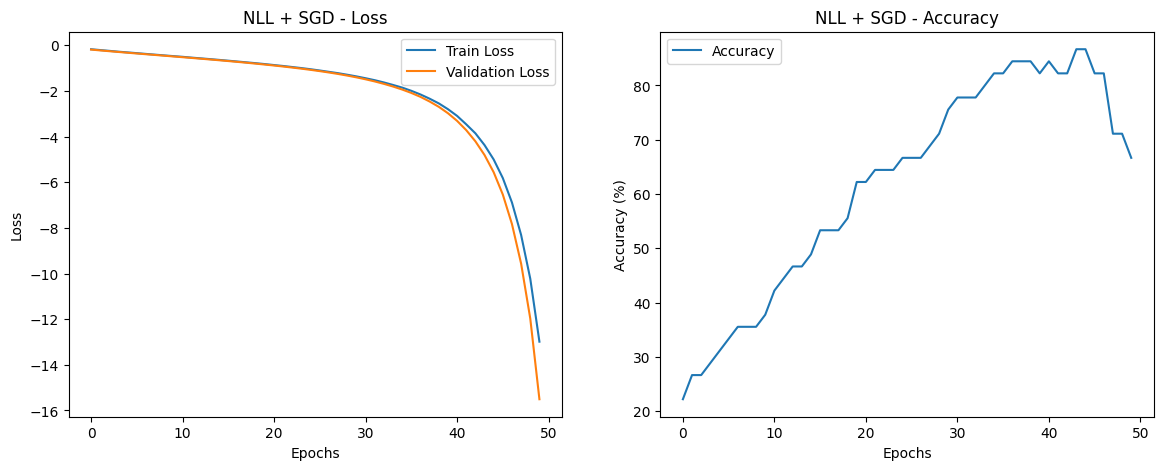

In [9]:
import torch.nn.functional as F

# Función para entrenar el modelo
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=50):
    train_losses = []
    val_losses = []
    accuracy = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            
            # Convertir labels a one-hot encoding si se usa MSELoss
            if isinstance(criterion, nn.MSELoss):
                labels = F.one_hot(labels, num_classes=outputs.size(1)).float()
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                
                # Convertir labels a one-hot encoding si se usa MSELoss
                if isinstance(criterion, nn.MSELoss):
                    labels = F.one_hot(labels, num_classes=outputs.size(1)).float()
                
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs, 1)
                
                # Si labels tiene más de una dimensión, aplicar argmax(1)
                if labels.dim() > 1:
                    correct += (predicted == labels.argmax(1)).sum().item()
                else:
                    correct += (predicted == labels).sum().item()
                
                total += labels.size(0)

        val_losses.append(val_loss / len(val_loader))
        accuracy.append(100 * correct / total)

    return train_losses, val_losses, accuracy

# Configuraciones para experimentar
combinations = [
    {"loss_fn": nn.CrossEntropyLoss(), "optimizer": optim.SGD, "regularization": None, "name": "CrossEntropy + SGD"},
    {"loss_fn": nn.CrossEntropyLoss(), "optimizer": optim.Adam, "regularization": None, "name": "CrossEntropy + Adam"},
    {"loss_fn": nn.CrossEntropyLoss(), "optimizer": optim.SGD, "regularization": "L2", "name": "CrossEntropy + SGD + L2"},
    {"loss_fn": nn.CrossEntropyLoss(), "optimizer": optim.SGD, "regularization": "L1", "name": "CrossEntropy + SGD + L1"},
    {"loss_fn": nn.CrossEntropyLoss(), "optimizer": optim.Adam, "regularization": "L2", "name": "CrossEntropy + Adam + L2"},
    {"loss_fn": nn.MSELoss(), "optimizer": optim.Adam, "regularization": None, "name": "MSE + Adam"},
    {"loss_fn": nn.MSELoss(), "optimizer": optim.SGD, "regularization": "Dropout", "name": "MSE + SGD + Dropout"},
    {"loss_fn": nn.NLLLoss(), "optimizer": optim.Adam, "regularization": "Dropout", "name": "NLL + Adam + Dropout"},
    {"loss_fn": nn.NLLLoss(), "optimizer": optim.SGD, "regularization": None, "name": "NLL + SGD"}
]

results = {}

# Ejecutar todas las combinaciones
for config in combinations:
    model = SimpleNN(input_size=4, hidden_size=10, output_size=3)
    
    if config["regularization"] == "L2":
        optimizer = config["optimizer"](model.parameters(), lr=0.01, weight_decay=0.01)
    elif config["regularization"] == "L1":
        optimizer = config["optimizer"](model.parameters(), lr=0.01)
    elif config["regularization"] == "Dropout":
        model = SimpleNNWithDropout(input_size=4, hidden_size=10, output_size=3)
        optimizer = config["optimizer"](model.parameters(), lr=0.01)
    else:
        optimizer = config["optimizer"](model.parameters(), lr=0.01)
    
    # Entrenamiento
    train_losses, val_losses, accuracy = train_model(model, train_loader, val_loader, config["loss_fn"], optimizer)
    
    # Guardar resultados
    results[config["name"]] = (train_losses, val_losses, accuracy)

# Graficar resultados
for key, (train_losses, val_losses, accuracy) in results.items():
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(f'{key} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(accuracy, label='Accuracy')
    plt.title(f'{key} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.show()
